In [1]:
#importing necesery libraries
import pandas as pd
import numpy as np
import seaborn as sb
import matplotlib.pyplot as plt
from statsmodels.tsa.stattools import adfuller
import statsmodels.api as sm
import itertools

In [2]:
#reading the data from downloaded flat files

#this dataframe contains the data fromn the website (passenger count)
df = pd.read_csv(r'C:\Users\ADMIN\Downloads\Kovai.Co Assessment\Light_Rail_Patronage.csv')

#this df contains the stringency index data at a daily level for each country
stringency_index_df= pd.read_csv(r'C:\Users\ADMIN\Downloads\Kovai.Co Assessment\owid-covid-data.csv')

#this df contains the data of all the public holidays in canberra
holiday_dates = pd.read_excel(r'C:\Users\ADMIN\Downloads\Kovai.Co Assessment\Holiday List.xlsx')

In [3]:
#formatting the date column
df.date = pd.to_datetime(df.date,dayfirst=True)

In [4]:
#filtering out Austrilia data from the dataframe
stringency_index_df=stringency_index_df[['date','stringency_index']][stringency_index_df.location=='Australia']

#formatting the date column
stringency_index_df.date=pd.to_datetime(stringency_index_df.date)

#merging the stringency index data as a column in the main data frame
df=pd.merge(df,stringency_index_df,how='left',on='date')

#since the stringency index df has data only till 2022 Dec, replacing 2023 dates with 0 (The covid pandemic subsided so stringency index =0)
df.stringency_index=np.where(df.stringency_index.isna(),0,df.stringency_index)

C:\Users\ADMIN\AppData\Local\Temp\ipykernel_6640\247078156.py:5: UserWarning: Parsing dates in DD/MM/YYYY format when dayfirst=False (the default) was specified. This may lead to inconsistently parsed dates! Specify a format to ensure consistent parsing.
  stringency_index_df.date=pd.to_datetime(stringency_index_df.date)


In [5]:
#chcking if there are any missing dates for which passenger count was not captured
tempdf = list(pd.date_range(start="2019-04-22", end='2023-08-15'))
temp1=list(pd.to_datetime(df.date))
a=[]
for i in tempdf:
    if(i not in temp1):
        a.append(i)
        missing_date = pd.DataFrame(a)
missing_date.rename(columns={0:'date'},inplace=True)

In [6]:
#There are two dates for which data was not captured. Both the dates were of Christmas (2019 & 2021). On googling, came to know that the canberra government had announced that the trains can be used free of charge
missing_date

,date
0,2019-12-25
1,2021-12-25


In [7]:
#replacing the values of myway, paper_ticket and total for the above dates with the average of the christmas dates available (2020 & 2022)
missing_date['myway']=float(df.myway[(df.date=='2022-12-25') | (df.date=='2020-12-25')].mean())
missing_date['paper_ticket']=float(df.paper_ticket[(df.date=='2022-12-25') | (df.date=='2020-12-25')].mean())
missing_date['total']=float(df.total[(df.date=='2022-12-25') | (df.date=='2020-12-25')].mean())

In [8]:
#replacing the missing stringency index value by the average of that month for each date
missing_date['stringency_index']=np.where(missing_date.date=='2019-12-25',float(stringency_index_df['stringency_index'][(stringency_index_df.date>='2019-12-01')&(stringency_index_df.date<='2019-12-31')].mean()),0)
missing_date['stringency_index']=np.where(missing_date.date=='2021-12-25',float(stringency_index_df['stringency_index'][(stringency_index_df.date>='2021-12-01')&(stringency_index_df.date<='2021-12-31')].mean()),missing_date.stringency_index)
missing_date.stringency_index=np.where(missing_date.stringency_index.isna(),0,missing_date.stringency_index)

#concating the data for the missing dates with the main datarame
df=pd.concat([df,missing_date],ignore_index=True)

In [9]:
#adding a column named weekend_flag in which saturdays and sundays are flagged 1
df['day_name'] = df['date'].dt.weekday
df['weekend_flag']=np.where((df.day_name ==5) | (df.day_name == 6),1,0)

In [10]:
#flagging the dates which are public holidays in canberra as 1 using the data obtained from external sources
holiday_dates.Date = pd.to_datetime(holiday_dates.Date)
holiday_dates['holiday_flag']=1
holiday_dates.rename(columns={'Date':'date'},inplace=True)
holiday_dates=holiday_dates[['date','holiday_flag']]

df=pd.merge(df,holiday_dates,how='left',on='date')
df.holiday_flag = np.where(df.holiday_flag==1,1,0)

In [11]:
#adding a column which has the month number of each date
df['month']=df.date.dt.month 

In [12]:
#adding a column in which the lockdown dates in canberra are flagged 
df['lockdown_flag']=np.where((df.date>='2021-08-12') & (df.date<='2021-10-15'),1,0)

In [13]:
#flagging the dates on which events like music concerts and sports events happened
df['event_flag']=np.where(df.paper_ticket>=1300,1,0)

Checking the stationarity of myway and paper_ticket data

ADF Test on myway Time Series:
ADF Statistic: -3.0185172286937063
p-value: 0.03320093810763863
Critical Values: {'1%': -3.44594128742536, '5%': -2.868413360220551, '10%': -2.570431271085555}
Is the time series stationary? True


ADF Test on paper_ticket Time Series:
ADF Statistic: -4.396125423463879
p-value: 0.00030155449963814406
Critical Values: {'1%': -3.441734108219804, '5%': -2.8665621113012514, '10%': -2.5694446417404313}
Is the time series stationary? True




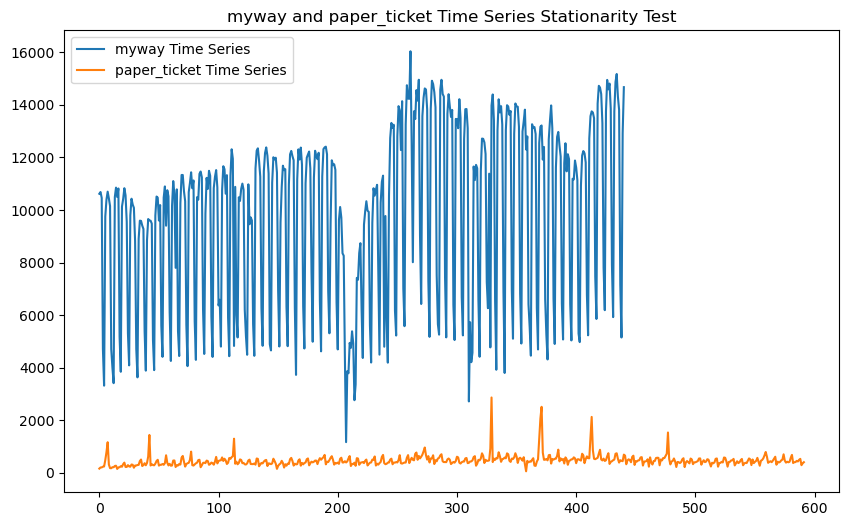

In [14]:
# Sample time series data (you should replace this with your actual data)
data_myway = list(df.myway[df.date>'2022-05-31'])
data_paper_ticket = list(df.paper_ticket[df.date>='2022-01-01'])

# Convert data to a pandas Series
time_series_myway = pd.Series(data_myway)
time_series_paper_ticket = pd.Series(data_paper_ticket)

# Define a function to perform ADF test and print results
def adf_test(time_series):
    result = adfuller(time_series)
    print("ADF Statistic:", result[0])
    print("p-value:", result[1])
    print("Critical Values:", result[4])
    print("Is the time series stationary?", result[1] <= 0.05)

# Perform ADF test on the myway time series
print("ADF Test on myway Time Series:")
adf_test(time_series_myway)
print("\n")

# Perform ADF test on the paper_ticket time series
print("ADF Test on paper_ticket Time Series:")
adf_test(time_series_paper_ticket)
print("\n")

# Plot the myway and paper_ticket time series
plt.figure(figsize=(10, 6))
plt.plot(time_series_myway, label='myway Time Series')
plt.plot(time_series_paper_ticket, label='paper_ticket Time Series')
plt.legend()
plt.title('myway and paper_ticket Time Series Stationarity Test')
plt.show()

In [15]:
 import pmdarima as pm
    
#Considering data post 2022 May for myway ticket forecasting since data before that is covid impacted
df1 = df[df.date>'2022-05-31']
data = list(df1.myway)

# Convert data to a pandas Series
time_series = pd.Series(data)

# Find best ARIMA order using AIC
best_order_myway = pm.auto_arima(time_series, seasonal=True, stepwise=True, trace=True).order

# Sample time series data (replace this with your own data)
data = list(df.paper_ticket[df.date>='2022-01-01'])

# Convert data to a pandas Series
time_series = pd.Series(data)

# Find best ARIMA order using AIC
best_order_ppr_tk = pm.auto_arima(time_series, seasonal=False, stepwise=True, trace=True).order

print("Best ARIMA Order myway:", best_order_myway)

print("Best ARIMA Order paper_ticket:", best_order_ppr_tk)

Performing stepwise search to minimize aic
 ARIMA(2,1,2)(0,0,0)[0] intercept   : AIC=8182.409, Time=1.29 sec
 ARIMA(0,1,0)(0,0,0)[0] intercept   : AIC=8438.447, Time=0.05 sec
 ARIMA(1,1,0)(0,0,0)[0] intercept   : AIC=8440.425, Time=0.06 sec
 ARIMA(0,1,1)(0,0,0)[0] intercept   : AIC=8440.373, Time=0.13 sec
 ARIMA(0,1,0)(0,0,0)[0]             : AIC=8436.452, Time=0.03 sec
 ARIMA(1,1,2)(0,0,0)[0] intercept   : AIC=inf, Time=1.06 sec
 ARIMA(2,1,1)(0,0,0)[0] intercept   : AIC=8227.748, Time=1.02 sec
 ARIMA(3,1,2)(0,0,0)[0] intercept   : AIC=8297.704, Time=1.37 sec
 ARIMA(2,1,3)(0,0,0)[0] intercept   : AIC=inf, Time=1.24 sec
 ARIMA(1,1,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.49 sec
 ARIMA(1,1,3)(0,0,0)[0] intercept   : AIC=8239.701, Time=0.88 sec
 ARIMA(3,1,1)(0,0,0)[0] intercept   : AIC=8245.706, Time=0.33 sec
 ARIMA(3,1,3)(0,0,0)[0] intercept   : AIC=8077.870, Time=1.24 sec
 ARIMA(4,1,3)(0,0,0)[0] intercept   : AIC=7986.785, Time=1.32 sec
 ARIMA(4,1,2)(0,0,0)[0] intercept   : AIC=7990.4

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                               myway   No. Observations:                  411
Model:             SARIMAX(5, 0, 2)x(1, 1, [], 52)   Log Likelihood               -2625.897
Date:                             Wed, 06 Sep 2023   AIC                           5273.794
Time:                                     02:17:06   BIC                           5314.609
Sample:                                          0   HQIC                          5290.125
                                             - 411                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
weekend_flag -6039.6753    171.580    -35.200      0.000   -6375.966   -5703.384
holiday_flag -6938.22

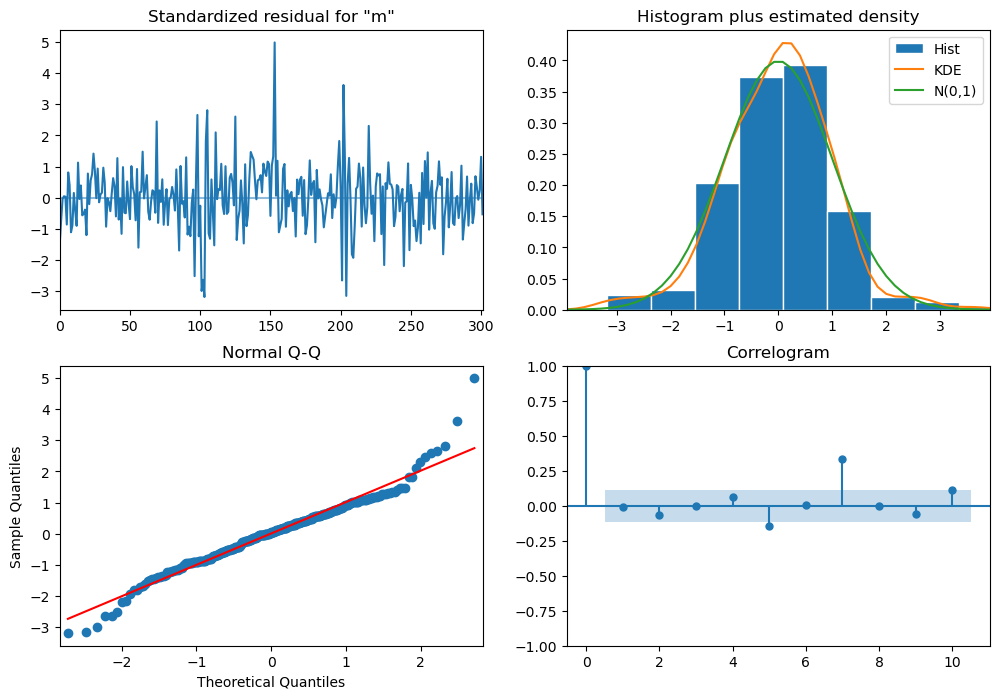

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [16]:
#training set 
df2=df1[df1.date<='2023-07-16']

order = (5, 0, 2)  # Non-seasonal (p, d, q) order
seasonal_order = (1, 1, 0, 52)  # Seasonal (P, D, Q, s) order
exog_data = df2[['weekend_flag','holiday_flag']]

model = sm.tsa.SARIMAX(df2['myway'], order=order, seasonal_order=seasonal_order, exog=exog_data ,enforce_stationarity=False)
results = model.fit()


print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()


forecast_steps = 30  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps, exog=exog_data[-forecast_steps:])
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [17]:
actuals =list(df1.myway[df1.date>'2023-07-16'])
forecast_mean=list(forecast_mean)
x=0
y=0
t=[]
for i in range(0,30):
    x=x+(forecast_mean[i]-actuals[i])/actuals[i]
    y=forecast_mean[i]-actuals[i]
    t.append(y)
x/30*100

-3.3740495746918446

In [18]:
#storing the predctions in a list
predictions_30_myway = forecast_mean

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           paper_ticket   No. Observations:                  562
Model:               SARIMAX(7, 0, 5)   Log Likelihood               -3709.810
Date:                Wed, 06 Sep 2023   AIC                           7445.620
Time:                        02:17:12   BIC                           7501.767
Sample:                             0   HQIC                          7467.553
                                - 562                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0761      0.299      0.255      0.799      -0.509       0.661
ar.L2          0.2041      0.137      1.488      0.137      -0.065       0.473
ar.L3          0.3228      0.125      2.586      0.0

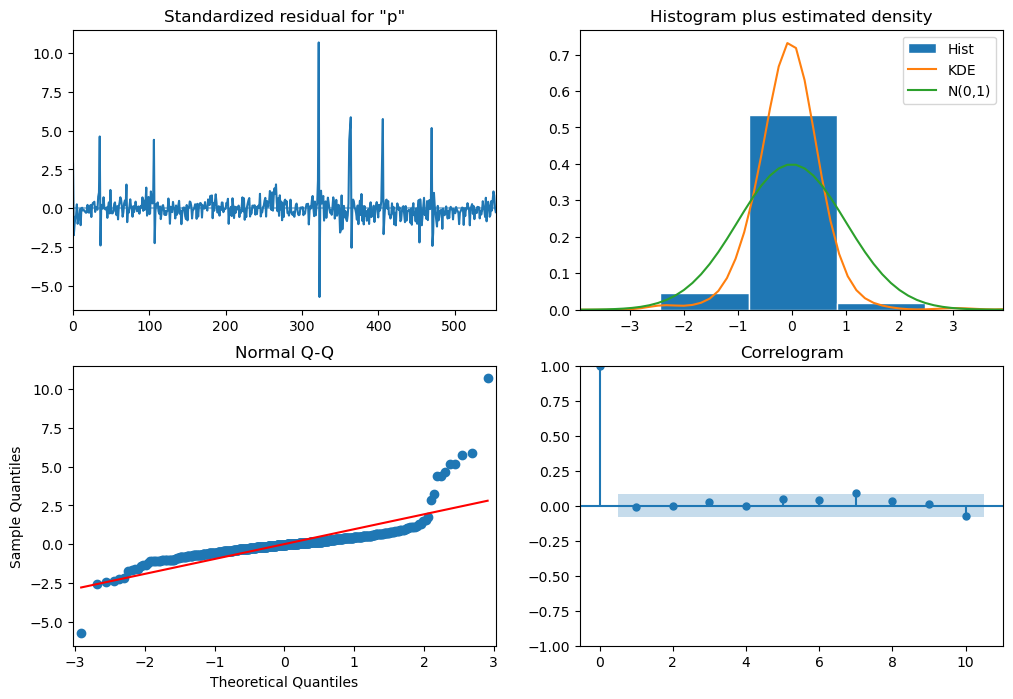

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [19]:
#training set 
df3=df[df.date>='2022-01-01']
df2=df3[df3.date<='2023-07-16']

order = (7, 0, 5)  # Non-seasonal (p, d, q) order
seasonal_order = (0, 1, 0, 52)  # Seasonal (P, D, Q, s) order
exog_data = df2[['weekend_flag','holiday_flag']]

model = sm.tsa.SARIMAX(df2['paper_ticket'], order=order,enforce_stationarity=False)
results = model.fit()


print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()


forecast_steps = 30  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps, exog=exog_data[-forecast_steps:])
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [20]:
actuals =list(df1.paper_ticket[df1.date>'2023-07-16'])
forecast_mean=list(forecast_mean)
x=0
y=0
t=[]
for i in range(0,30):
    x=x+(forecast_mean[i]-actuals[i])/actuals[i]
    y=forecast_mean[i]-actuals[i]
    t.append(y)
x/30*100

5.345034166615138

In [21]:
#storing the predctions in a list
predictions_30_paper_ticket=forecast_mean

#getting the total ticket value by summing myway and paper_ticket
predictions_30=[]
for i in range (0,30):
    predictions_30.append(predictions_30_paper_ticket[i]+predictions_30_myway[i])

In [22]:
actuals =list(df1.total[df1.date>'2023-07-16'])
forecast_mean=predictions_30
x=0
y=0
t=[]
for i in range(0,30):
    x=x+(forecast_mean[i]-actuals[i])/actuals[i]
    y=forecast_mean[i]-actuals[i]
    t.append(y)
x/30*100

-4.00681109490221

In [23]:
#P10, P50 and P90 predictions and the error in the prediction

p10_pred = np.percentile(predictions_30,10)
p10_actual = np.percentile(actuals,10)

p50_pred = np.percentile(predictions_30,50)
p50_actual = np.percentile(actuals,50)

p90_pred = np.percentile(predictions_30,90)
p90_actual = np.percentile(actuals,90)

p10_error = ((p10_pred/p10_actual)-1)*100
p50_error = ((p50_pred/p50_actual)-1)*100
p90_error = ((p90_pred/p90_actual)-1)*100

print('Predicted P10:', p10_pred)
print('Actual P10:', p10_actual)
print('P10 Error % :',p10_error)

print('\nPredicted P50:', p50_pred)
print('Actual P50:',p50_actual)
print('P50 Error % :',p50_error)

print('\nPredicted P90:', p90_pred)
print('Actual P90:',p90_actual)
print('P90 Error % :',p90_error)

Predicted P10: 6353.738344531755
Actual P10: 6617.6
P10 Error % : -3.987271147670546

Predicted P50: 11524.323354658001
Actual P50: 14158.5
P50 Error % : -18.604913270063903

Predicted P90: 12864.367645571996
Actual P90: 15234.1
P90 Error % : -15.555447019699253


Forecast for next 14 days

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'


                                      SARIMAX Results                                      
Dep. Variable:                               myway   No. Observations:                  427
Model:             SARIMAX(5, 0, 2)x(1, 1, [], 52)   Log Likelihood               -2775.953
Date:                             Wed, 06 Sep 2023   AIC                           5573.906
Time:                                     02:18:04   BIC                           5615.289
Sample:                                          0   HQIC                          5590.435
                                             - 427                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
weekend_flag -6158.1371    238.952    -25.771      0.000   -6626.475   -5689.799
holiday_flag -7012.78

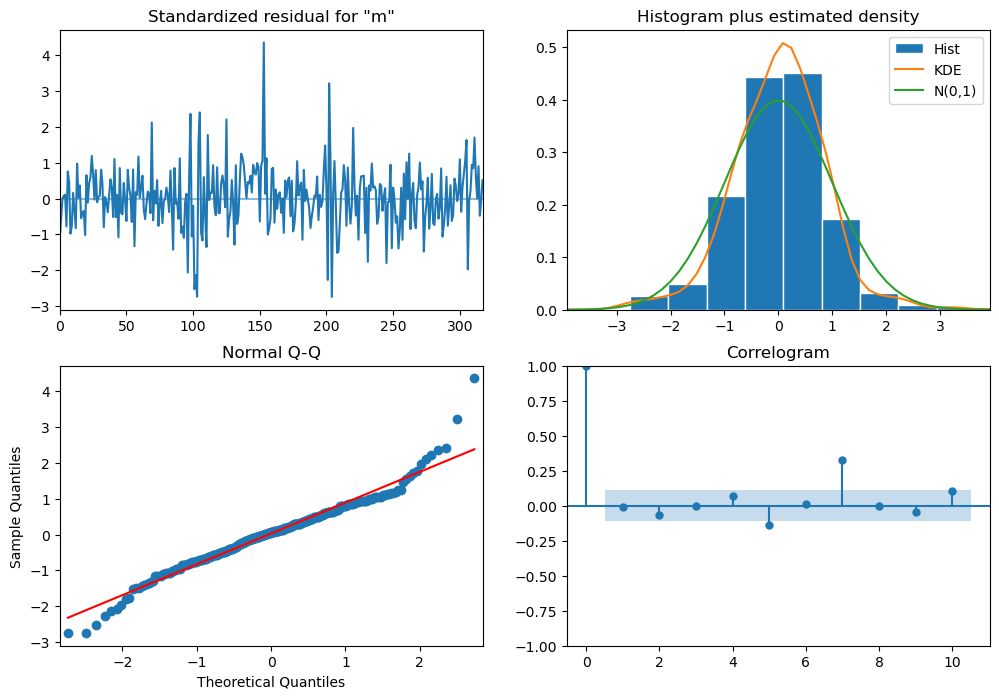

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [24]:
#training set 
df2=df1[df1.date<='2023-08-01']

order = (5, 0, 2)  # Non-seasonal (p, d, q) order
seasonal_order = (1, 1, 0, 52)  # Seasonal (P, D, Q, s) order
exog_data = df2[['weekend_flag','holiday_flag']]

model = sm.tsa.SARIMAX(df2['myway'], order=order, seasonal_order=seasonal_order, exog=exog_data ,enforce_stationarity=False)
results = model.fit()


print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()


forecast_steps = 14  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps, exog=exog_data[-forecast_steps:])
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [25]:
actuals =list(df1.myway[df1.date>'2023-08-01'])
forecast_mean=list(forecast_mean)
x=0
y=0
t=[]
for i in range(0,14):
    x=x+(forecast_mean[i]-actuals[i])/actuals[i]
    y=forecast_mean[i]-actuals[i]
    t.append(y)
x/14*100

3.0168359333783057

In [26]:
#storing the predctions in a list
predictions_14_myway = forecast_mean

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           paper_ticket   No. Observations:                  578
Model:               SARIMAX(7, 0, 5)   Log Likelihood               -3809.988
Date:                Wed, 06 Sep 2023   AIC                           7645.975
Time:                        02:18:09   BIC                           7702.491
Sample:                             0   HQIC                          7668.024
                                - 578                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0794      0.307      0.258      0.796      -0.523       0.682
ar.L2          0.1737      0.154      1.126      0.260      -0.129       0.476
ar.L3          0.3434      0.137      2.505      0.0

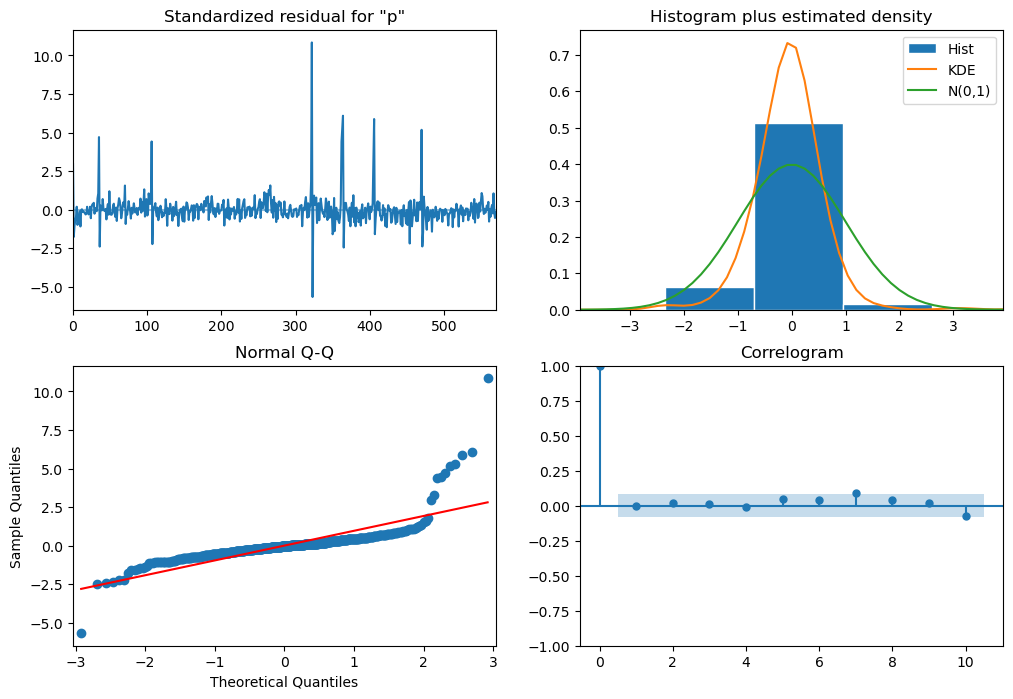

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [27]:
#training set 
df3=df[df.date>='2022-01-01']
df2=df3[df3.date<='2023-08-01']

order = (7, 0, 5)  # Non-seasonal (p, d, q) order
seasonal_order = (0, 1, 0, 52)  # Seasonal (P, D, Q, s) order
exog_data = df2[['weekend_flag','holiday_flag']]

model = sm.tsa.SARIMAX(df2['paper_ticket'], order=order,enforce_stationarity=False)
results = model.fit()


print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()


forecast_steps = 14  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps, exog=exog_data[-forecast_steps:])
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [28]:
actuals =list(df1.paper_ticket[df1.date>'2023-08-01'])
forecast_mean=list(forecast_mean)
x=0
y=0
t=[]
for i in range(0,14):
    x=x+(forecast_mean[i]-actuals[i])/actuals[i]
    y=forecast_mean[i]-actuals[i]
    t.append(y)
x/14*100

7.014003338031345

In [29]:
#storing the predctions in a list
predictions_14_paper_ticket=forecast_mean

#getting the total ticket value by summing myway and paper_ticket
predictions_14=[]
for i in range (0,14):
    predictions_14.append(predictions_14_paper_ticket[i]+predictions_14_myway[i])

In [30]:
actuals =list(df1.total[df1.date>'2023-08-01'])
forecast_mean=predictions_14
x=0
y=0
t=[]
for i in range(0,14):
    x=x+(forecast_mean[i]-actuals[i])/actuals[i]
    y=forecast_mean[i]-actuals[i]
    t.append(y)
x/14*100

2.986468173347409

In [31]:
#P10, P50 and P90 predictions and the error in the prediction

p10_pred = np.percentile(predictions_14,10)
p10_actual = np.percentile(actuals,10)

p50_pred = np.percentile(predictions_14,50)
p50_actual = np.percentile(actuals,50)

p90_pred = np.percentile(predictions_14,90)
p90_actual = np.percentile(actuals,90)

p10_error = ((p10_pred/p10_actual)-1)*100
p50_error = ((p50_pred/p50_actual)-1)*100
p90_error = ((p90_pred/p90_actual)-1)*100

print('Predicted P10:', p10_pred)
print('Actual P10:', p10_actual)
print('P10 Error % :',p10_error)

print('\nPredicted P50:', p50_pred)
print('Actual P50:',p50_actual)
print('P50 Error % :',p50_error)

print('\nPredicted P90:', p90_pred)
print('Actual P90:',p90_actual)
print('P90 Error % :',p90_error)

Predicted P10: 8074.14817879464
Actual P10: 6716.9
P10 Error % : 20.20646695342556

Predicted P50: 14110.929213566696
Actual P50: 14368.5
P50 Error % : -1.7926073454661462

Predicted P90: 14649.893424429898
Actual P90: 15264.7
P90 Error % : -4.027636151186087


Forecast for 7 days

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\statespace\sarimax.py:978: UserWarning: Non-invertible starting MA parameters found. Using zeros as starting parameters.
  warn('Non-invertible starting MA parameters found.'
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                                      SARIMAX Results                                      
Dep. Variable:                               myway   No. Observations:                  434
Model:             SARIMAX(5, 0, 2)x(1, 1, [], 52)   Log Likelihood               -2827.842
Date:                             Wed, 06 Sep 2023   AIC                           5677.684
Time:                                     02:20:10   BIC                           5719.306
Sample:                                          0   HQIC                          5694.296
                                             - 434                                         
Covariance Type:                               opg                                         
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
weekend_flag -6111.5660    172.666    -35.395      0.000   -6449.984   -5773.148
holiday_flag -7116.08

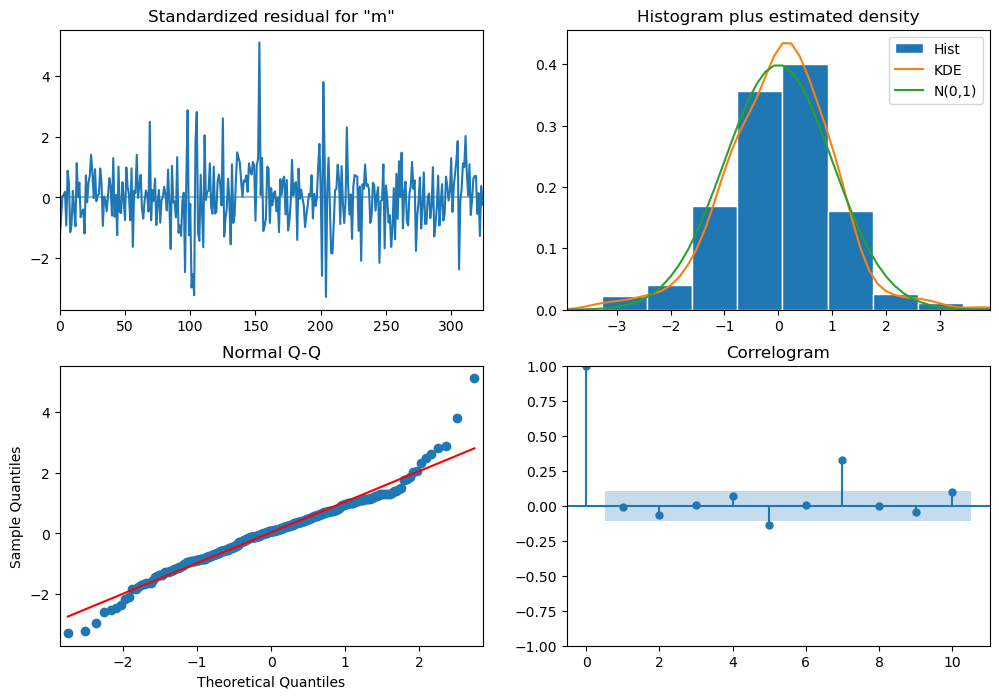

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [32]:
#training set 
df2=df1[df1.date<='2023-08-08']

order = (5, 0, 2)  # Non-seasonal (p, d, q) order
seasonal_order = (1, 1, 0, 52)  # Seasonal (P, D, Q, s) order
exog_data = df2[['weekend_flag','holiday_flag']]

model = sm.tsa.SARIMAX(df2['myway'], order=order, seasonal_order=seasonal_order, exog=exog_data ,enforce_stationarity=False)
results = model.fit()


print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()


forecast_steps = 7  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps, exog=exog_data[-forecast_steps:])
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [33]:
actuals =list(df1.myway[df1.date>'2023-08-08'])
forecast_mean=list(forecast_mean)
x=0
y=0
t=[]
for i in range(0,7):
    x=x+(forecast_mean[i]-actuals[i])/actuals[i]
    y=forecast_mean[i]-actuals[i]
    t.append(y)
x/7*100

3.764294378936079

In [34]:
#storing the predctions in a list
predictions_7_myway = forecast_mean

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:473: ValueWarning: An unsupported index was provided and will be ignored when e.g. forecasting.
  self._init_dates(dates, freq)
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\base\model.py:607: ConvergenceWarning: Maximum Likelihood optimization failed to converge. Check mle_retvals
  warnings.warn("Maximum Likelihood optimization failed to "


                               SARIMAX Results                                
Dep. Variable:           paper_ticket   No. Observations:                  585
Model:               SARIMAX(7, 0, 5)   Log Likelihood               -3853.653
Date:                Wed, 06 Sep 2023   AIC                           7733.307
Time:                        02:20:14   BIC                           7789.981
Sample:                             0   HQIC                          7755.406
                                - 585                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
ar.L1          0.0792      0.291      0.273      0.785      -0.490       0.649
ar.L2          0.1771      0.141      1.253      0.210      -0.100       0.454
ar.L3          0.3438      0.127      2.707      0.0

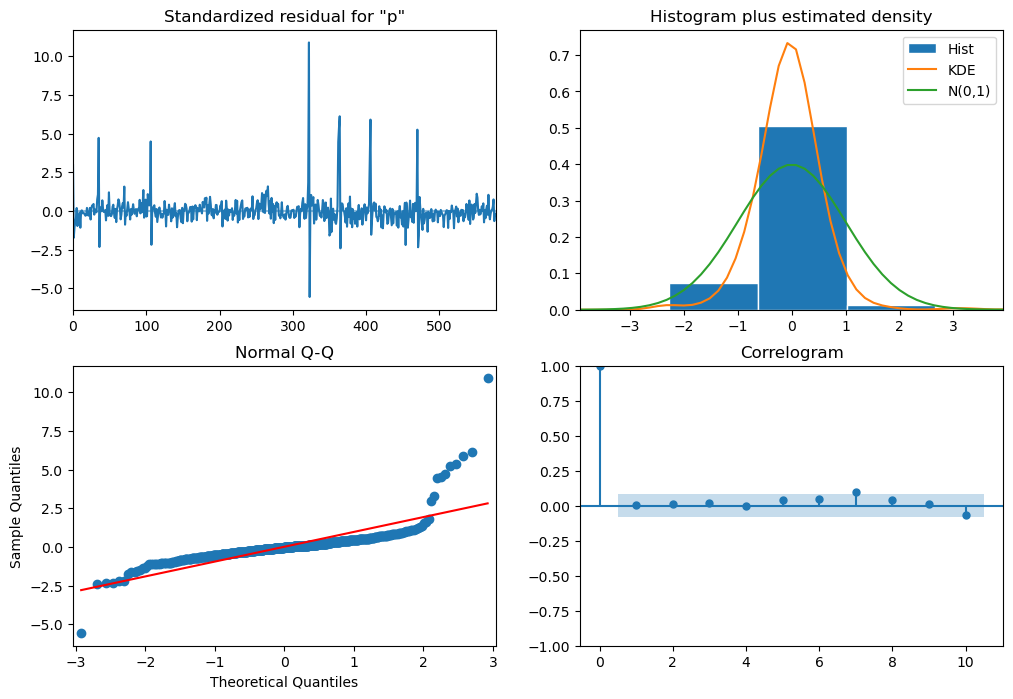

C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  return get_prediction_index(
C:\Users\ADMIN\anaconda3\Lib\site-packages\statsmodels\tsa\base\tsa_model.py:836: FutureWarning: No supported index is available. In the next version, calling this method in a model without a supported index will result in an exception.
  return get_prediction_index(


In [35]:
#training set 
df3=df[df.date>='2022-01-01']
df2=df3[df3.date<='2023-08-08']

order = (7, 0, 5)  # Non-seasonal (p, d, q) order
seasonal_order = (0, 1, 0, 52)  # Seasonal (P, D, Q, s) order
exog_data = df2[['weekend_flag','holiday_flag']]

model = sm.tsa.SARIMAX(df2['paper_ticket'], order=order,enforce_stationarity=False)
results = model.fit()


print(results.summary())
results.plot_diagnostics(figsize=(12, 8))
plt.show()


forecast_steps = 7  # Number of steps to forecast
forecast = results.get_forecast(steps=forecast_steps, exog=exog_data[-forecast_steps:])
forecast_mean = forecast.predicted_mean
forecast_conf_int = forecast.conf_int()

In [36]:
actuals =list(df1.paper_ticket[df1.date>'2023-08-08'])
forecast_mean=list(forecast_mean)
x=0
y=0
t=[]
for i in range(0,7):
    x=x+(forecast_mean[i]-actuals[i])/actuals[i]
    y=forecast_mean[i]-actuals[i]
    t.append(y)
x/7*100

11.840280561143766

In [37]:
#storing the predctions in a list
predictions_7_paper_ticket=forecast_mean

#getting the total ticket value by summing myway and paper_ticket
predictions_7=[]
for i in range (0,7):
    predictions_7.append(predictions_7_paper_ticket[i]+predictions_7_myway[i])

In [38]:
actuals =list(df1.total[df1.date>'2023-08-08'])
forecast_mean=predictions_7
x=0
y=0
t=[]
for i in range(0,7):
    x=x+(forecast_mean[i]-actuals[i])/actuals[i]
    y=forecast_mean[i]-actuals[i]
    t.append(y)
x/7*100

4.03869129832607

In [39]:
#P10, P50 and P90 predictions and the error in the prediction

p10_pred = np.percentile(predictions_7,10)
p10_actual = np.percentile(actuals,10)

p50_pred = np.percentile(predictions_7,50)
p50_actual = np.percentile(actuals,50)

p90_pred = np.percentile(predictions_7,90)
p90_actual = np.percentile(actuals,90)

p10_error = ((p10_pred/p10_actual)-1)*100
p50_error = ((p50_pred/p50_actual)-1)*100
p90_error = ((p90_pred/p90_actual)-1)*100

print('Predicted P10:', p10_pred)
print('Actual P10:', p10_actual)
print('P10 Error % :',p10_error)

print('\nPredicted P50:', p50_pred)
print('Actual P50:',p50_actual)
print('P50 Error % :',p50_error)

print('\nPredicted P90:', p90_pred)
print('Actual P90:',p90_actual)
print('P90 Error % :',p90_error)

Predicted P10: 7472.102765111084
Actual P10: 6791.6
P10 Error % : 10.019770968712582

Predicted P50: 14337.945629805838
Actual P50: 14312.0
P50 Error % : 0.18128584269030412

Predicted P90: 14659.048410870715
Actual P90: 15298.4
P90 Error % : -4.179205597508783
